# Детекција на знаковен јазик

Во рамки на оваа вежба ќе работиме со моделот OpenPose кој ќе ни овозможи детекција на знаковен јазик. За таа цел го користиме open source кодот кој се наоѓа на [овој линк](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git).

Внимавајте да го стартувате овој код користејќи GPU. За таа цел во рамки на овој notebook изберете Runtime -> Change runtime type -> GPU.

## Инсталирање на OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
 
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  
  # install python dependencies
  !pip install -q youtube-dl
  
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

## Симнување на видео од Youtube на кое е претставен Корејски знаковен јазик

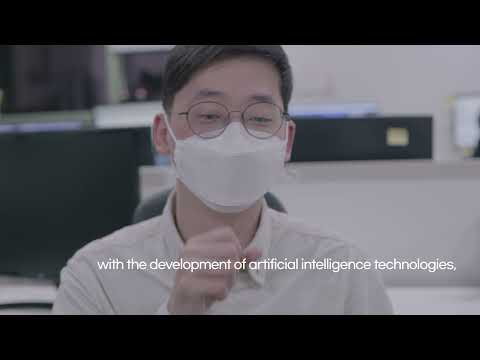

In [2]:
KSL_ID = 'VjainPzPo2k'
YouTubeVideo(KSL_ID)

Откако ова видео ќе се симне, истото треба да го процесираме со помош на OpenPose. Во основа, OpenPose не прави анотација на позиција на лице и дланки. За да ги додадеме, ставаме '--hand' и '--face' како што е направено подолу во кодот.

Резултатот е фајл во .avi формат, но ќе направиме конверзија во .mp4 формат со цел да имаме полесно процесирање. Ваквата конверзија ја правиме со помош на ffmpeg.

Резултатите кои ги добиваме (outputs) се следните:
- со --write_json: добиваме auto-annotation резултати во json фајл, т.ш. за секоја рамка (frame) на видеото еден ваков фајл ќе биде креиран
- со --write_video: добиваме видео кое ги вклучува и анотациите за позиции

In [ ]:
def download_youtube(youtube_id, start_time=10, duration=5):
  !rm -rf clip*.mp4
  !rm -rf openpose/output/*

  # # download the youtube with the given ID
  !youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$youtube_id

  # just pick a section where sign language is done
  !ffmpeg -y -loglevel info -ss $start_time -t $duration -i youtube.mp4 clip.mp4
  
  # # detect poses on the these 10 seconds
  !rm openpose.avi
  !cd openpose && ./build/examples/openpose/openpose.bin --face --hand --video ../clip.mp4 --write_json ./output_json/ --display 0  --write_video ../clip_openpose.avi
  # convert the result into MP4
  !ffmpeg -y -loglevel info -i clip_openpose.avi clip_openpose.mp4

download_youtube(KSL_ID)

Од видеото кое го симнавме, ги земаме првите 10 секунди и правиме детекција на позициите на лицето и дланките за тие 10 секунди.

Потоа, го визуелизираме резултатот.

## Визуелизација на резултатот

### Видео

OpenPose ни дава како резултат видео фајл кој содржи superimposed keypoint анотации. Да погледнеме како може да го прикажеме тоа.


In [4]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('clip_openpose.mp4', width=960, height=720)

Output hidden; open in https://colab.research.google.com to view.

### Слики

Она што всушност OpenPose го прави е поделба на видеото на индивидуални рамки (frames) и потоа врши auto анотација на секоја слика. 
За да го погледнеме деталниот резултат, користиме ffmpeg за да видиме како видеото се дели на повеќе frames (1 frame = 1 рамка = 1 слика).

Ја користиме оваа команда за таа цел:
`-vf fps=30`

Сите фајлови ги именуваме секвенцијално за да може полесно да ги користиме. 

## Конверзија на видеото во frames (рамки, слики)

In [ ]:
!rm openpose/images/video_out*.png
!mkdir openpose/output_images/
!cd openpose && ffmpeg -ss 10 -t 5 -i ../youtube.mp4 ./output_images/out%05d.png -vf fps=30

# Визуелизација на key points на сликите

In [6]:
import cv2
import glob
import json
import numpy as np
import os

from matplotlib import pyplot as plt

def load_images(path):
    path = os.path.join(path,'*')
    files = glob.glob(path)
    
    # We sort the images in alphabetical order to match them
    #  to the annotation files
    files.sort()

    X_raw = []
    for file in files:
        image = cv2.imread(file)
        X_raw.append(np.array(image))

    return X_raw
        
def from_json(path):
    """
    save json data to path
    """
    file = open(path, 'r', encoding='utf-8')
    return json.load(file)

def extract_openpose_anns(ann_json):
  def extract_keypoints(ann_json):
    X = []
    Y = []
    C = []
    id = 0
    while id < len(ann_json):
      if ann_json[id] != 0:
        X.append(ann_json[id])
        Y.append(ann_json[id+1])
        C.append(ann_json[id+2])
        id += 3
      else:
        id += 1
  
    return np.array([X, Y, C])

  kp_pose = extract_keypoints(ann_json['people'][0]['pose_keypoints_2d'])
  kp_face = extract_keypoints(ann_json['people'][0]['face_keypoints_2d'])
  kp_hand_left = extract_keypoints(ann_json['people'][0]['hand_left_keypoints_2d'])
  kp_hand_right = extract_keypoints(ann_json['people'][0]['hand_right_keypoints_2d'])

  pose = {}
  pose['pose'] = kp_pose
  pose['face'] = kp_face
  pose['hand_left'] = kp_hand_left
  pose['hand_right'] = kp_hand_right

  return pose

def extract_pose_annotations(path):
  path = os.path.join(path,'*')
  files = glob.glob(path)
  files.sort()

  Y_raw = []
  for file in files:
    ann_json = from_json(file)
    ann = extract_openpose_anns(ann_json)
    Y_raw.append(ann)

  return Y_raw

## Вчитување на сликите и key point фајловите
Откако сме ги дефинирале сите методи, сега ги повикуваме за да ги вчитаме сликите и key point annotation фајловите.


In [7]:
X_raw = load_images("openpose/output_images/")
len(X_raw)

150

In [8]:
Y_raw = extract_pose_annotations("openpose/output_json/")
len(Y_raw)

150

## Претставување на сликите заедно со key points

За крај, ги прикажуваме заедно сликите со key points.

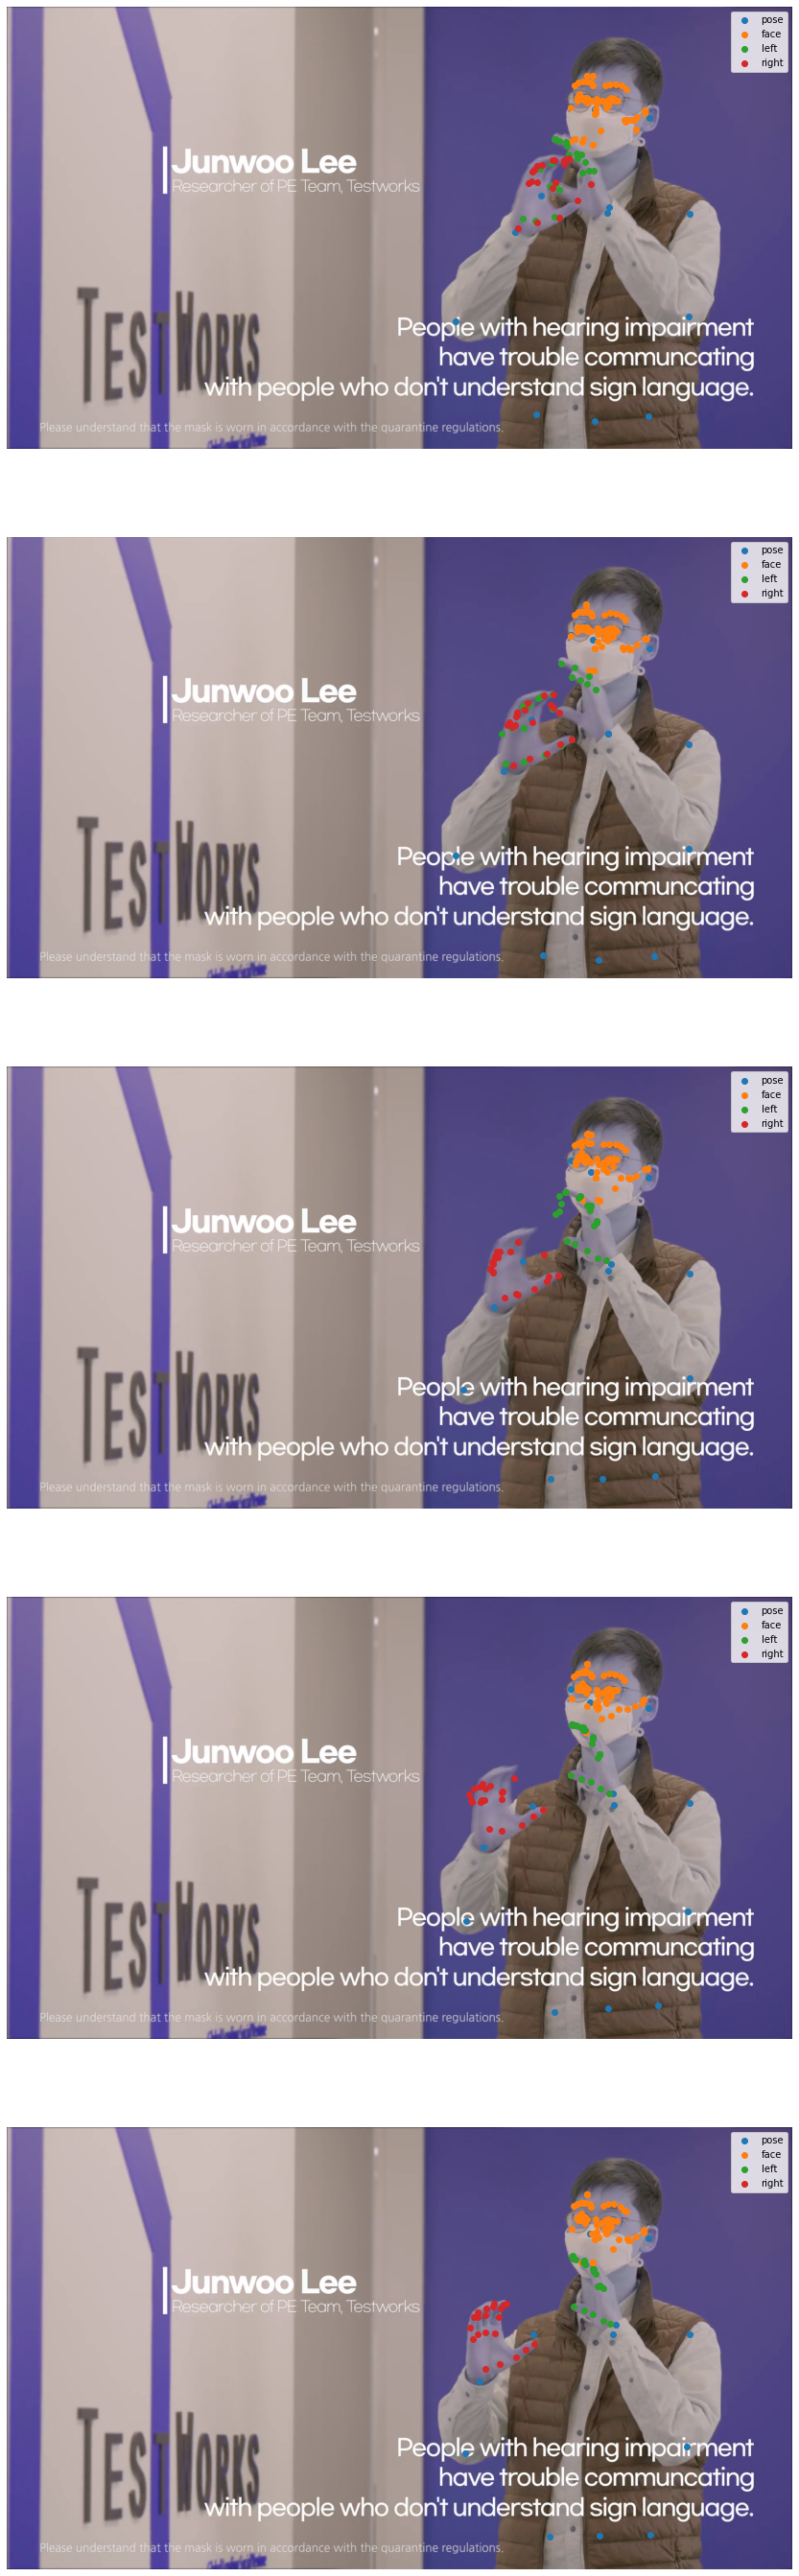

In [9]:
import matplotlib.pyplot as plt

def plot_pose(X, Y, start_id=0, end_id=10):
  # fig, ax = plt.subplots()
  fig = plt.figure(figsize=(100, 100))

  for id in range(start_id, end_id):
    x = X[id]
    y = Y[id]

    ax = fig.add_subplot(10, 1, id - start_id + 1)
    plt.axis('off')

    ax.imshow(x)

    ax.scatter(y['pose'][0], y['pose'][1], label='pose')
    ax.scatter(y['face'][0], y['face'][1], label='face')
    ax.scatter(y['hand_left'][0], y['hand_left'][1], label='left')
    ax.scatter(y['hand_right'][0], y['hand_right'][1], label='right')
    ax.legend()

  # ax.invert_yaxis()

plot_pose(X_raw, Y_raw, start_id=140, end_id=145)

Со ова ја завршуваме вежбата, успешно применувајќи еден модел за работа со знаковен јазик! 